<a href="https://colab.research.google.com/github/prp20/tensorflow_learning/blob/main/notebooks/Tensorflow_training_imdbReview_using_tfds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import re
import string
tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<[^>]+>', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [4]:
def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/{model_name}', monitor='val_loss', save_best_only='True', verbose=1)
  ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights='True')
  return [MC, ES]

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Brothers with psychokinetic powers (yes, really) duel not just for Debra Winger's affections but really over a secret from their childhood that left them at odds over their powers.<br /><br />There are surreal touches (the fire brigade that act like a singing Greek chorus), but there is also humour and romance. The soundtrack is great similar to the way American Werewolf in London used every great Wolf song they could get ~ but with fire ~ and I don't think I'll ever forget Dennis Quaid (mmmmm Dennis Quaid), setting his own trailer a rockin' to 'She's a lady' ~ priceless ;)<br /><br />Best line missing from the quotes section btw ~ 'Once you've had a clown, you never go back!'<br /><br />I love this movie (I ordered the DVD from the US) and if the comments written by the kind of people who'd be happier with Legally Blond 3 don't put you off ~ give it a try :)"
 b'I\'m 14 years old and I love this cartoon. Burt Reynolds and Dom Deluise make a great pair. This movie is really 

In [10]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
vectorize_layer.adapt(train_dataset.map(lambda text, label: text))

In [11]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U17')

In [12]:
from tensorflow.keras import layers
max_features = 10000
sequence_length = 250
embedding = layers.Embedding(max_features + 1, 16)

In [13]:
input = layers.Input(shape=(), dtype=tf.string)
x = vectorize_layer(input)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(input, outputs, name = "NLP_model_1")

In [14]:

model_1.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_1 = model_1.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=get_callbacks(model_1.name))

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.6903
Epoch 1: val_loss improved from inf to 0.63530, saving model to saved_models/NLP_model_1
391/391 [==============================] - 11s 20ms/step - loss: 0.6707 - accuracy: 0.6905 - val_loss: 0.6353 - val_accuracy: 0.7466
Epoch 2/10
388/391 [============================>.] - ETA: 0s - loss: 0.5802 - accuracy: 0.7878
Epoch 2: val_loss improved from 0.63530 to 0.54048, saving model to saved_models/NLP_model_1
391/391 [==============================] - 6s 16ms/step - loss: 0.5797 - accuracy: 0.7884 - val_loss: 0.5405 - val_accuracy: 0.7990
Epoch 3/10
386/391 [============================>.] - ETA: 0s - loss: 0.4845 - accuracy: 0.8328
Epoch 3: val_loss improved from 0.54048 to 0.46504, saving model to saved_models/NLP_model_1
391/391 [==============================] - 7s 17ms/step - loss: 0.4841 - accuracy: 0.8329 - val_loss: 0.4650 - val_accuracy: 0.8288
Epoch 4/10
388/391 [====================

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) *100
  model_precision, model_recall, model_f1score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"Accuracy": model_accuracy, "Precision": model_precision, "Recall value": model_recall, "F1-Score": model_f1score}

  return model_results

In [16]:
model_1 = tf.keras.models.load_model(f"saved_models/{model_1.name}")
results = model_1.predict(test_dataset.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))

391/391 [==============================] - 2s 6ms/step


In [17]:
#get original labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [18]:
calculate_results(y_true, results)

{'Accuracy': 87.09599999999999,
 'Precision': 0.870960237414552,
 'Recall value': 0.87096,
 'F1-Score': 0.8709599793535966}

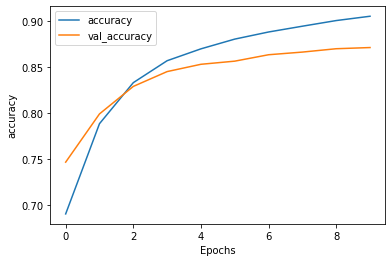

In [19]:
plot_graphs(history_1, 'accuracy')

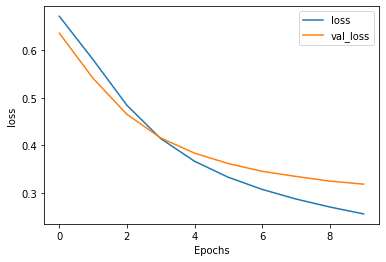

In [20]:
plot_graphs(history_1, 'loss')

In [21]:
#Model 2 with LSTM
from tensorflow.keras import layers

input = layers.Input(shape=(), dtype="string")
x = vectorize_layer(input)
x = embedding(x)
x = layers.LSTM(units=64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(input, output, name="nlp_model_2_LSTM")
model_2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_2 = model_2.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=get_callbacks(model_2.name))

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 0.4490 - accuracy: 0.8224
Epoch 1: val_loss improved from inf to 0.50806, saving model to saved_models/nlp_model_2_LSTM


391/391 [==============================] - 29s 58ms/step - loss: 0.4490 - accuracy: 0.8224 - val_loss: 0.5081 - val_accuracy: 0.7955
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7535
Epoch 2: val_loss did not improve from 0.50806
391/391 [==============================] - 14s 36ms/step - loss: 0.5077 - accuracy: 0.7535 - val_loss: 0.5669 - val_accuracy: 0.7117
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.7653
Epoch 3: val_loss did not improve from 0.50806
391/391 [==============================] - 14s 36ms/step - loss: 0.5029 - accuracy: 0.7653 - val_loss: 0.6045 - val_accuracy: 0.7065
Epoch 4/10
390/391 [============================>.] - ETA: 0s - loss: 0.5519 - accuracy: 0.7359
Epoch 4: val_loss did not improve from 0.50806
391/391 [==============================] - 15s 37ms/step - loss: 0.5518 - accuracy: 0.7360 - val_loss: 0.5849 - val_accuracy: 0.7114
Epoch 5/10
391/391 [===================

In [22]:
model_2 = tf.keras.models.load_model(f"saved_models/{model_2.name}")
results = model_2.predict(test_dataset.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))

391/391 [==============================] - 6s 13ms/step


In [23]:
calculate_results(y_true, results)

{'Accuracy': 79.552,
 'Precision': 0.801497070891478,
 'Recall value': 0.79552,
 'F1-Score': 0.7945015166366941}

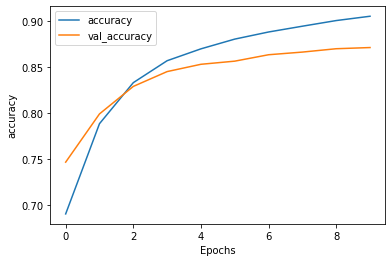

In [24]:
plot_graphs(history_1, 'accuracy')

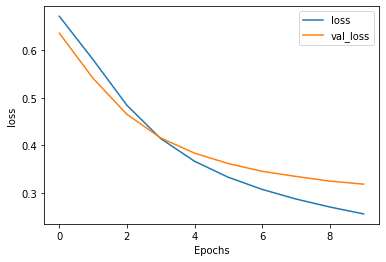

In [25]:
plot_graphs(history_1, 'loss')

In [26]:
# Model 3
from tensorflow.keras import layers

input = layers.Input(shape=(), dtype="string")
x = vectorize_layer(input)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(input, output, name="nlp_model_3_GRU")
model_3.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_3 = model_3.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=get_callbacks(model_3.name))

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7179
Epoch 1: val_loss improved from inf to 0.37674, saving model to saved_models/nlp_model_3_GRU


391/391 [==============================] - 33s 74ms/step - loss: 0.5214 - accuracy: 0.7179 - val_loss: 0.3767 - val_accuracy: 0.8526
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9042
Epoch 2: val_loss improved from 0.37674 to 0.32824, saving model to saved_models/nlp_model_3_GRU


391/391 [==============================] - 32s 80ms/step - loss: 0.2412 - accuracy: 0.9042 - val_loss: 0.3282 - val_accuracy: 0.8612
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9137
Epoch 3: val_loss did not improve from 0.32824
391/391 [==============================] - 19s 49ms/step - loss: 0.2181 - accuracy: 0.9137 - val_loss: 0.3349 - val_accuracy: 0.8664
Epoch 4/10
390/391 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9225
Epoch 4: val_loss improved from 0.32824 to 0.30733, saving model to saved_models/nlp_model_3_GRU


391/391 [==============================] - 28s 72ms/step - loss: 0.2008 - accuracy: 0.9225 - val_loss: 0.3073 - val_accuracy: 0.8702
Epoch 5/10
391/391 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9355
Epoch 5: val_loss did not improve from 0.30733
391/391 [==============================] - 21s 52ms/step - loss: 0.1699 - accuracy: 0.9355 - val_loss: 0.3544 - val_accuracy: 0.8626
Epoch 6/10
391/391 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9480
Epoch 6: val_loss did not improve from 0.30733
391/391 [==============================] - 20s 50ms/step - loss: 0.1429 - accuracy: 0.9480 - val_loss: 0.3669 - val_accuracy: 0.8616
Epoch 7/10
391/391 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9576
Epoch 7: val_loss did not improve from 0.30733
391/391 [==============================] - 19s 47ms/step - loss: 0.1203 - accuracy: 0.9576 - val_loss: 0.4154 - val_accuracy: 0.8532
Epoch 8/10
391/391 [===================

In [27]:
model_3 = tf.keras.models.load_model(f"saved_models/{model_3.name}")
results = model_3.predict(test_dataset.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
calculate_results(y_true, results)

391/391 [==============================] - 7s 17ms/step


{'Accuracy': 87.024,
 'Precision': 0.8704477257468097,
 'Recall value': 0.87024,
 'F1-Score': 0.8702218069661426}

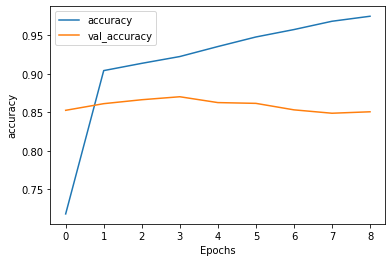

In [28]:
plot_graphs(history_3, 'accuracy')

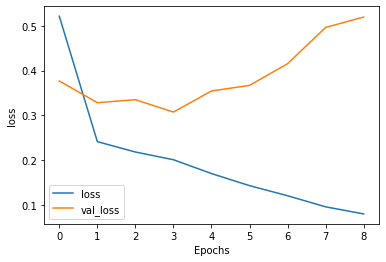

In [29]:
plot_graphs(history_3, 'loss')

In [30]:
from tensorflow.keras import layers

input = layers.Input(shape=(), dtype="string")
x = vectorize_layer(input)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_3_1 = tf.keras.Model(input, output, name="nlp_model_3_GRU_1")
model_3_1.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_3_1 = model_3_1.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=get_callbacks(model_3_1.name))

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 0.2258 - accuracy: 0.9179
Epoch 1: val_loss improved from inf to 0.33454, saving model to saved_models/nlp_model_3_GRU_1


391/391 [==============================] - 25s 55ms/step - loss: 0.2256 - accuracy: 0.9179 - val_loss: 0.3345 - val_accuracy: 0.8660
Epoch 2/10
389/391 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9401
Epoch 2: val_loss did not improve from 0.33454
391/391 [==============================] - 14s 36ms/step - loss: 0.1634 - accuracy: 0.9402 - val_loss: 0.3876 - val_accuracy: 0.8614
Epoch 3/10
390/391 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9516
Epoch 3: val_loss did not improve from 0.33454
391/391 [==============================] - 14s 36ms/step - loss: 0.1379 - accuracy: 0.9516 - val_loss: 0.3638 - val_accuracy: 0.8566
Epoch 4/10
389/391 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9602
Epoch 4: val_loss did not improve from 0.33454
391/391 [==============================] - 15s 38ms/step - loss: 0.1175 - accuracy: 0.9602 - val_loss: 0.4462 - val_accuracy: 0.8400
Epoch 5/10
389/391 [===================

In [31]:
model_3_1 = tf.keras.models.load_model(f"saved_models/{model_3_1.name}")
results = model_3_1.predict(test_dataset.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
calculate_results(y_true, results)

391/391 [==============================] - 6s 13ms/step


{'Accuracy': 86.6,
 'Precision': 0.8671056540953257,
 'Recall value': 0.866,
 'F1-Score': 0.8658990281905126}

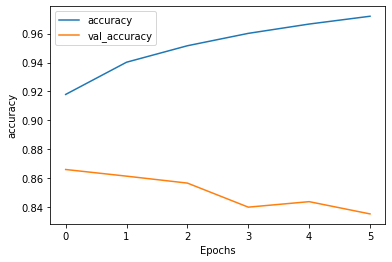

In [32]:
plot_graphs(history_3_1, 'accuracy')

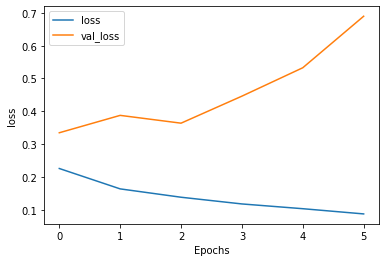

In [33]:
plot_graphs(history_3_1, 'loss')

In [34]:
from tensorflow.keras import layers

input = layers.Input(shape=(), dtype="string")
x = vectorize_layer(input)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(input, output, name="nlp_model_4_BI_LSTM")
model_4.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_4 = model_4.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=get_callbacks(model_4.name))

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9313
Epoch 1: val_loss improved from inf to 0.36267, saving model to saved_models/nlp_model_4_BI_LSTM


391/391 [==============================] - 58s 135ms/step - loss: 0.1967 - accuracy: 0.9313 - val_loss: 0.3627 - val_accuracy: 0.8598
Epoch 2/10
390/391 [============================>.] - ETA: 0s - loss: 0.1510 - accuracy: 0.9466
Epoch 2: val_loss did not improve from 0.36267
391/391 [==============================] - 29s 74ms/step - loss: 0.1509 - accuracy: 0.9466 - val_loss: 0.3739 - val_accuracy: 0.8606
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9560
Epoch 3: val_loss did not improve from 0.36267
391/391 [==============================] - 29s 75ms/step - loss: 0.1300 - accuracy: 0.9560 - val_loss: 0.3933 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9632
Epoch 4: val_loss did not improve from 0.36267
391/391 [==============================] - 25s 63ms/step - loss: 0.1139 - accuracy: 0.9632 - val_loss: 0.4658 - val_accuracy: 0.8422
Epoch 5/10
391/391 [==================

In [35]:
model_4 = tf.keras.models.load_model(f"saved_models/{model_4.name}")
results = model_4.predict(test_dataset.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
calculate_results(y_true, results)

391/391 [==============================] - 9s 21ms/step


{'Accuracy': 85.98,
 'Precision': 0.8613059207653924,
 'Recall value': 0.8598,
 'F1-Score': 0.8596537594418924}

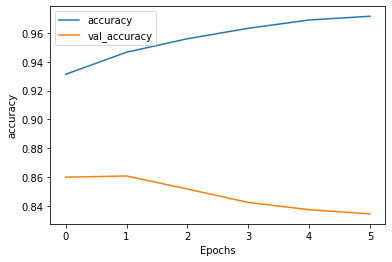

In [37]:
plot_graphs(history_4, 'accuracy')

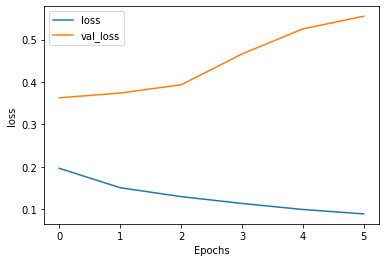

In [36]:
plot_graphs(history_4, 'loss')

In [38]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(), dtype="string")
x = vectorize_layer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, 1, activation='relu',padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, output, name="NLP_model_5_CNN")
model_5.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_5 = model_5.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=get_callbacks(model_5.name))

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.8385
Epoch 1: val_loss improved from inf to 0.38583, saving model to saved_models/NLP_model_5_CNN


391/391 [==============================] - 12s 18ms/step - loss: 0.3696 - accuracy: 0.8385 - val_loss: 0.3858 - val_accuracy: 0.8310
Epoch 2/10
390/391 [============================>.] - ETA: 0s - loss: 0.3379 - accuracy: 0.8552
Epoch 2: val_loss improved from 0.38583 to 0.37864, saving model to saved_models/NLP_model_5_CNN


391/391 [==============================] - 7s 18ms/step - loss: 0.3378 - accuracy: 0.8552 - val_loss: 0.3786 - val_accuracy: 0.8366
Epoch 3/10
386/391 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8710
Epoch 3: val_loss improved from 0.37864 to 0.36997, saving model to saved_models/NLP_model_5_CNN


391/391 [==============================] - 7s 17ms/step - loss: 0.3093 - accuracy: 0.8706 - val_loss: 0.3700 - val_accuracy: 0.8407
Epoch 4/10
390/391 [============================>.] - ETA: 0s - loss: 0.2657 - accuracy: 0.8917
Epoch 4: val_loss improved from 0.36997 to 0.36189, saving model to saved_models/NLP_model_5_CNN


391/391 [==============================] - 7s 17ms/step - loss: 0.2657 - accuracy: 0.8917 - val_loss: 0.3619 - val_accuracy: 0.8458
Epoch 5/10
391/391 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9163
Epoch 5: val_loss did not improve from 0.36189
391/391 [==============================] - 6s 15ms/step - loss: 0.2185 - accuracy: 0.9163 - val_loss: 0.3654 - val_accuracy: 0.8434
Epoch 6/10
391/391 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9374
Epoch 6: val_loss did not improve from 0.36189
391/391 [==============================] - 6s 14ms/step - loss: 0.1702 - accuracy: 0.9374 - val_loss: 0.3965 - val_accuracy: 0.8441
Epoch 7/10
391/391 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9582
Epoch 7: val_loss did not improve from 0.36189
391/391 [==============================] - 6s 16ms/step - loss: 0.1207 - accuracy: 0.9582 - val_loss: 0.4246 - val_accuracy: 0.8490
Epoch 8/10
386/391 [=======================

In [40]:
model_5 = tf.keras.models.load_model(f"saved_models/{model_5.name}")
results = model_5.predict(test_dataset.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
calculate_results(y_true, results)

391/391 [==============================] - 2s 6ms/step


{'Accuracy': 84.576,
 'Precision': 0.8459073598560094,
 'Recall value': 0.84576,
 'F1-Score': 0.8457435713201301}

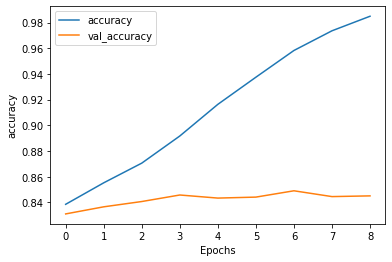

In [41]:
plot_graphs(history_5, 'accuracy')

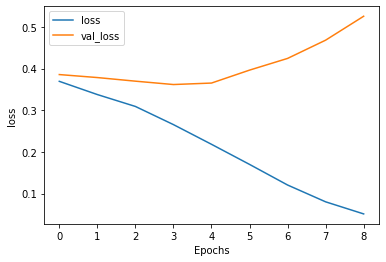

In [42]:
plot_graphs(history_5, 'loss')

In [43]:
from tensorflow.keras import layers
import tensorflow_hub as hub

sentence_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype="string", trainable=False)

In [44]:
model_6 = tf.keras.models.Sequential([
    sentence_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation="sigmoid")
], name="nlp_model_6_use")

model_6.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_6 = model_6.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=get_callbacks(model_6.name))

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8328
Epoch 1: val_loss improved from inf to 0.32961, saving model to saved_models/nlp_model_6_use
391/391 [==============================] - 81s 189ms/step - loss: 0.4017 - accuracy: 0.8328 - val_loss: 0.3296 - val_accuracy: 0.8550
Epoch 2/10
390/391 [============================>.] - ETA: 0s - loss: 0.3275 - accuracy: 0.8581
Epoch 2: val_loss improved from 0.32961 to 0.32469, saving model to saved_models/nlp_model_6_use
391/391 [==============================] - 56s 144ms/step - loss: 0.3274 - accuracy: 0.8582 - val_loss: 0.3247 - val_accuracy: 0.8570
Epoch 3/10
390/391 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.8623
Epoch 3: val_loss did not improve from 0.32469
391/391 [==============================] - 48s 122ms/step - loss: 0.3211 - accuracy: 0.8623 - val_loss: 0.3265 - val_accuracy: 0.8560
Epoch 4/10
390/391 [============================>.] - ETA: 0s - loss: 0.3

In [45]:
model_6 = tf.keras.models.load_model(f"saved_models/{model_6.name}")
results = model_6.predict(test_dataset.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
calculate_results(y_true, results)

391/391 [==============================] - 28s 72ms/step


{'Accuracy': 86.02,
 'Precision': 0.8602539723855332,
 'Recall value': 0.8602,
 'F1-Score': 0.8601947636787567}

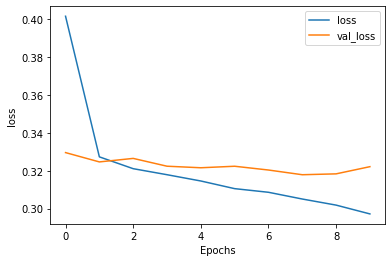

In [46]:
plot_graphs(history_6, 'loss')

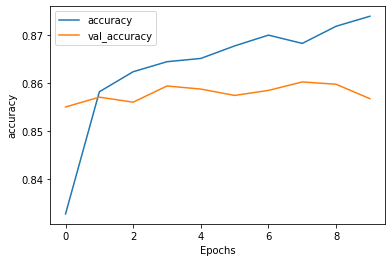

In [47]:
plot_graphs(history_6, 'accuracy')

In [51]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

FileNotFoundError: ignored

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model_7 = tf.keras.Model(inputs=[text_input], outputs = [l], name="model_7_BERT")
model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_7.fit(train_dataset, epochs=5, batch_size = 32, validation_dataset=test_dataset, callbacks=get_callbacks(model_7.name))

In [ ]:
model_7 = tf.keras.models.load_model(f"saved_models/{model_7.name}")
results = model_7.predict(test_dataset.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
calculate_results(y_true, results)